In [24]:
import numpy as np
import torch
import torch.nn as nn

from IPython.display import clear_output

from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

In [25]:
# nets
from dec_utility_scripts import StackedAutoEncoder, StackedDenoisingAutoEncoder
from dec_utility_scripts import DEC, IDEC, IDEC_loss
from dec_utility_scripts import cluster_acc, predict_cluster_accuracy # hungarian algorithm

# dataset&train_cycles
from dec_utility_scripts import train, evaluate

# visualization
from dec_utility_scripts import plot_stats, plot_stats_dec, plot_stats_idec


In [26]:
class EmbeddingsDataset(Dataset):
    def __init__(self, features, text, labels, train):
        assert len(features) == len(text) == len(labels)
        # self.features = features
        self.labels = labels.tolist()
        self.text = text

        embeddings_ds = TensorDataset(
            features, 
            labels
        ) 
        train_idx, val_idx = train_test_split(
            list(range(len(embeddings_ds))), test_size=.1, shuffle=True
        )
        if train == -1:
            self.ds = embeddings_ds
        else:
            self.ds = Subset(embeddings_ds, train_idx) if train else Subset(embeddings_ds, val_idx)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index):
        data = self.ds[index][0]
        _class = self.ds[index][1]
        return (data, _class)

    def get_text_by_labels(self, lbl):
        _dict = {self.labels[i]: self.text[i] for i in range(len(self.labels))}

        return np.vectorize(_dict.get)(lbl) if isinstance(lbl, (list, np.ndarray)) else _dict[lbl]



In [27]:
txt_labels = np.load(r'/kaggle/input/embaug-dataset/embaug_txt_labels.npy', allow_pickle=True)

num_labels = torch.Tensor(
    np.load(r'/kaggle/input/embaug-dataset/embaug_num_labels.npy')
)

In [28]:
# embeddings = torch.Tensor(np.load(r'/kaggle/input/embaug-dataset/embaug_meanpooling_layer.npy'))
embeddings = torch.Tensor(np.load(r'/kaggle/input/embaug-dataset/embaug_maxpooling_layer.npy'))

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)
static_loader =  DataLoader(train_dataset, batch_size=256, pin_memory=False, shuffle=False)

# Train&valid cycle

In [29]:
def whole_train_valid_cycle(
    model, scheduler, optimizer, loss_fn, device, title,
    num_epochs:int = 100,
    patience_threshold:tuple = None,
    save_best_params_as:str = None
):
    train_loss_history, valid_loss_history = [], []
    
    best_valid_loss = np.inf
    patience = 0

    train_acc_history, train_nmi_history, train_ari_history = [], [], []
    val_acc_history, val_nmi_history, val_ari_history = [], [], []
    
    if type(model) == IDEC:
        train_rec_loss_history, train_cl_loss_history = [], []

    for epoch in range(num_epochs):

        if isinstance(model, DEC):

            train_loss, train_y, train_y_pred, = train(model, train_loader, optimizer, loss_fn, device, static_loader)
            valid_loss, val_targets, val_predicted = evaluate(model, valid_loader, loss_fn, device)
            
            if type(model) == IDEC:

                train_rec_loss, train_cl_loss = train_loss['rec'], train_loss['clust']
                train_loss = train_loss['total']
                
                
                train_rec_loss_history.append(train_rec_loss)
                train_cl_loss_history.append(train_cl_loss)
                

            train_acc = cluster_acc(train_y, train_y_pred)
            train_nmi = normalized_mutual_info_score(train_y, train_y_pred)
            train_ari = adjusted_rand_score(train_y, train_y_pred)

            train_acc_history.append(train_acc)
            train_nmi_history.append(train_nmi)
            train_ari_history.append(train_ari)

            val_acc = cluster_acc(val_targets, val_predicted)
            val_nmi = normalized_mutual_info_score(val_targets, val_predicted)
            val_ari = adjusted_rand_score(val_targets, val_predicted)

            val_acc_history.append(val_acc)
            val_nmi_history.append(val_nmi)
            val_ari_history.append(val_ari)
        
 
        elif isinstance(model, StackedAutoEncoder):
            train_loss = train(model, train_loader, optimizer, loss_fn, device)
            valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        print('patience:', patience)
        if patience_threshold == None:
            pass
        elif patience_threshold[0] is not None and len(valid_loss_history)>1:
            if round(valid_loss_history[-2], patience_threshold[1]) \
            == round(valid_loss, patience_threshold[1]):
                patience += 1
            else:
                patience = 0

            if patience == patience_threshold[0]:
                print('Training stopped. Patience threshold was reached')
                break
        else:
            pass


        clear_output(wait=True)
        

        if isinstance(model, DEC):
            if type(model) == DEC:
                plot_stats_dec(
                    train_loss_history, valid_loss_history, 
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )
            if type(model) == IDEC:
                plot_stats_idec(
                    train_loss_history, valid_loss_history, 
                    train_rec_loss_history, 
                    train_cl_loss_history,
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )

        elif isinstance(model, StackedAutoEncoder):
            plot_stats(
                train_loss_history, valid_loss_history,
                title
            )

            # scheduler only for autoencoder
            scheduler.step() if not scheduler == None else None


        if not save_best_params_as == None:
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), save_best_params_as)
                print(f"Model parameters saved to '{save_best_params_as}'")                  
        
        

## Initialize

In [31]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla P100-PCIE-16GB


### Getting baseline KMeans score

In [9]:
"""save your time: it's .51 for 'max_pooling_layer'"""

# km_baseline = KMeans(n_clusters=7, random_state=0, n_init=20).fit_predict(embeddings)

# cluster_acc(
#     num_labels.numpy(),
#     km_baseline
# )

"save your time: it's .51 for 'max_pooling_layer'"

# Dataset Augmentation

First of all, we should get a clear picture of what we want to get from our augmentation. In practice of unsupervised learning:
- We do not know which sample correlates to which class *a priori*
- But we do have initial guess of how many KMeans clusters do we have (n_clusters=7)
- To augment samples we can use backtranslation technique

#### num. 7 'max_pooling__layer' aug

In [11]:
embeddings = torch.Tensor(np.load(r'/kaggle/input/embaug-dataset/embaug_maxpooling_layer.npy'))

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
static_loader =  DataLoader(train_dataset, batch_size=256, pin_memory=False, shuffle=False)

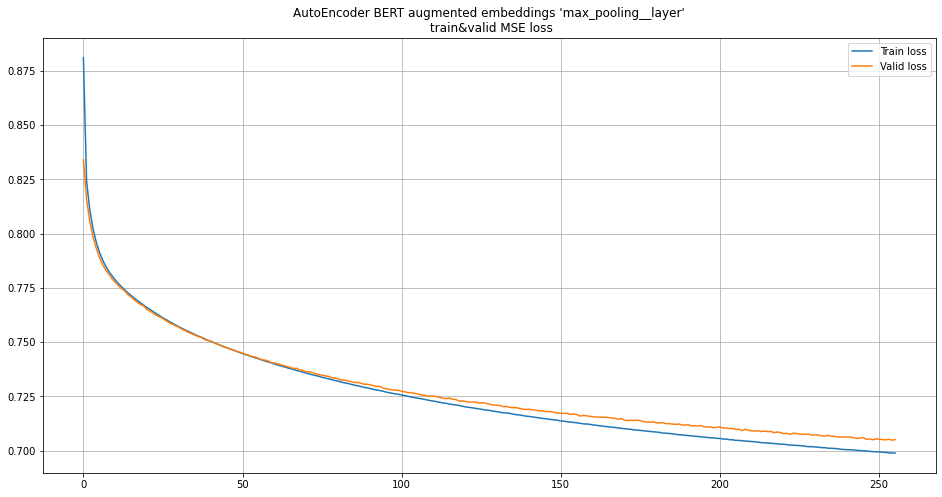

Evaluation: 100%|██████████| 28/28 [00:00<00:00, 112.46it/s]

patience: 9
Training stopped. Patience threshold was reached


In [83]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

optimizer = Adam(model.parameters(), lr=1e-4, )
# scheduler = StepLR(optimizer, step_size=100, gamma=10) 


whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 3),
    # save_best_params_as = './ae_weights/bertembaug_train_7.pt',
    title="AutoEncoder BERT augmented embeddings 'max_pooling__layer'\n train&valid MSE"
)

In [85]:
torch.save(model.state_dict(),'bertembaug_train_7.pt')

## DEC (ae with dropout)

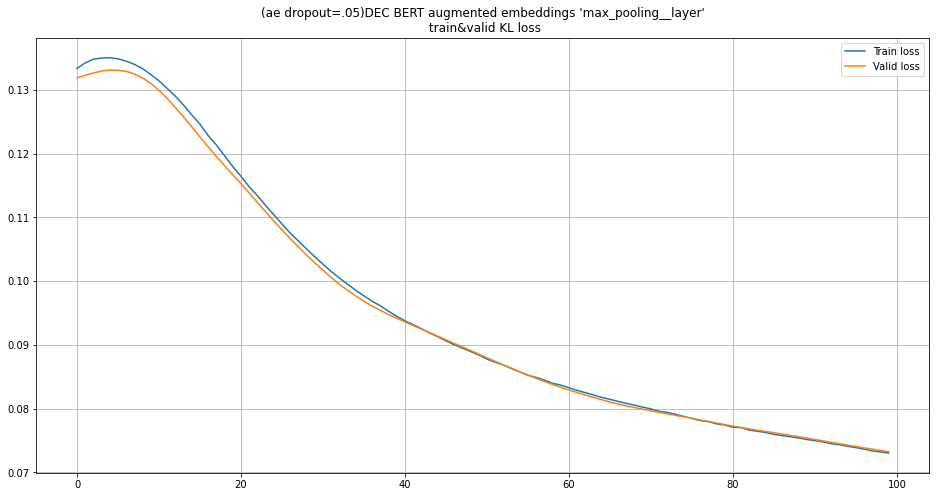

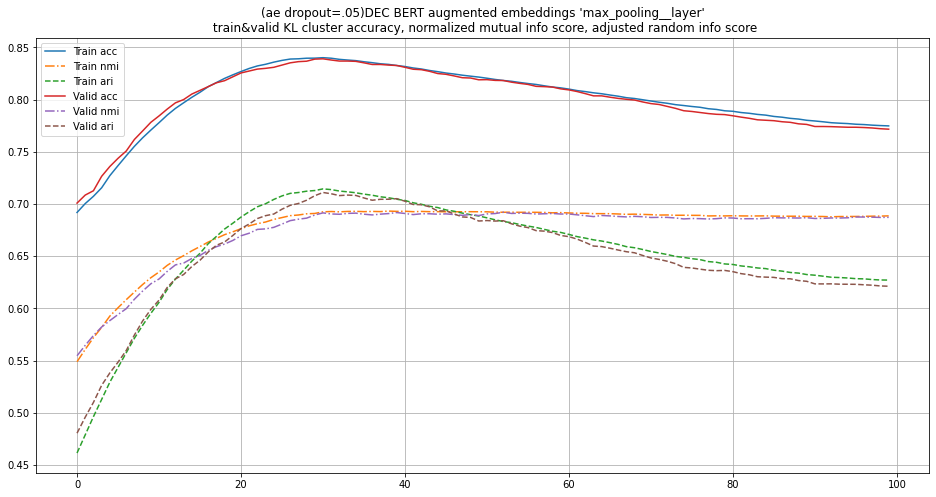

In [86]:
# model with autoencoder dropout=.05
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'/kaggle/working/bertembaug_train_7_drop.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-6)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    patience_threshold=(10,4),
    device = device,
#     save_best_params_as='bertembaug_dec_weights_7.pt',
    title="(ae dropout=.05)DEC BERT augmented embeddings 'max_pooling__layer'\n train&valid KL"
)


Cluster accuracy degrading slowlier, which is good. However performace is not so good

## DEC

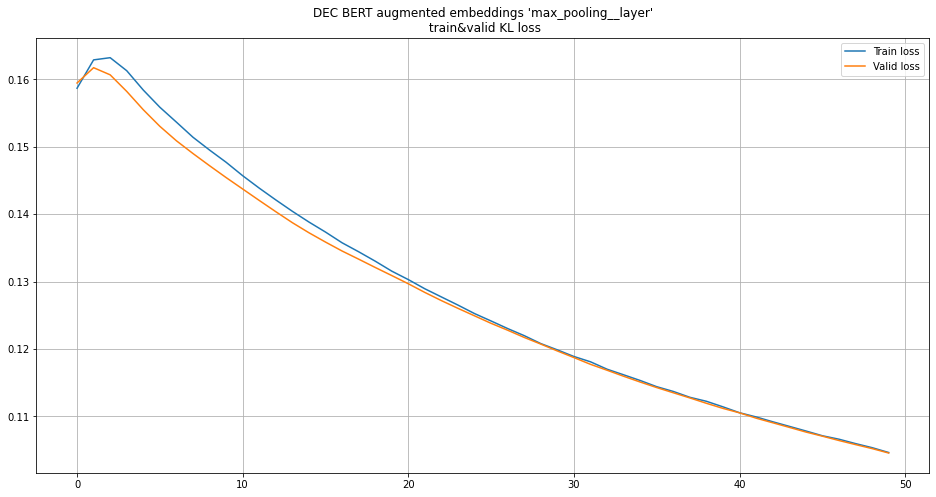

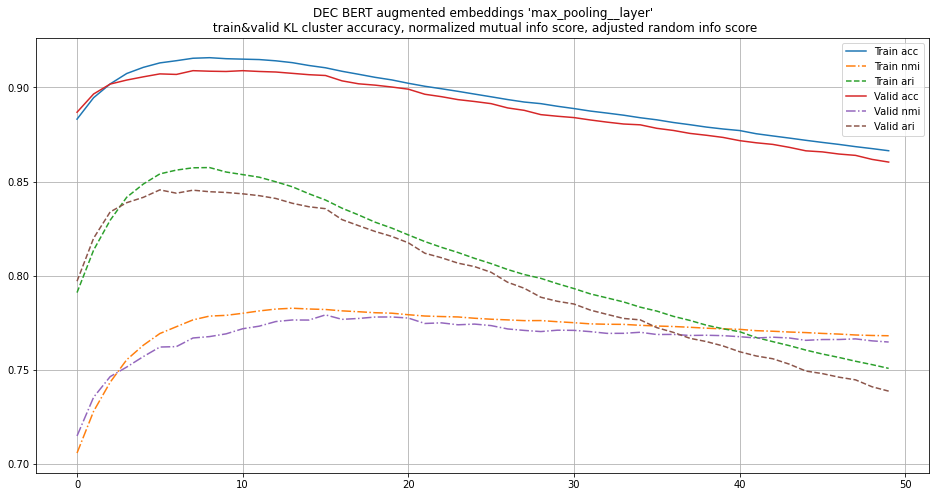

Model parameters saved to 'bertembaug_dec_weights_7.pt'


In [93]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'/kaggle/working/bertembaug_train_7.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-6)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 50,
    patience_threshold=(10,4),
    device = device,
    save_best_params_as='bertembaug_dec_weights_7.pt',
    title="DEC BERT augmented embeddings 'max_pooling__layer'\n train&valid KL"
)


## IDEC

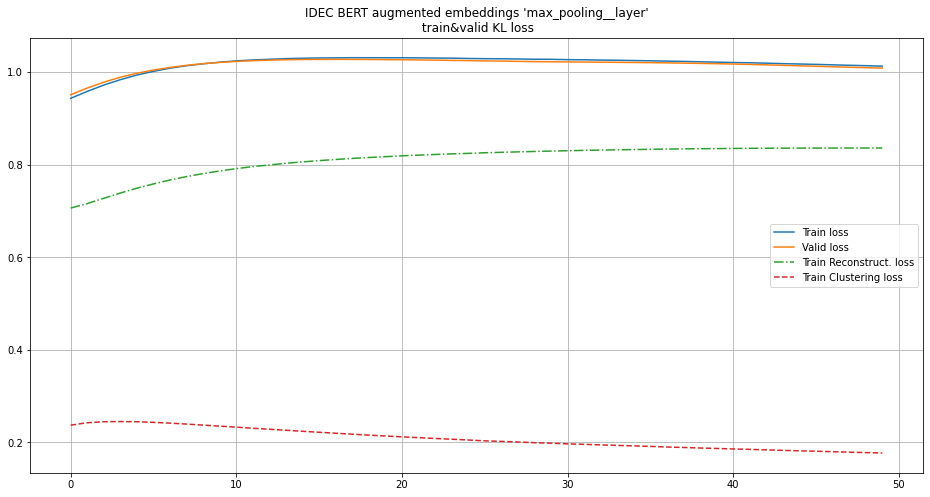

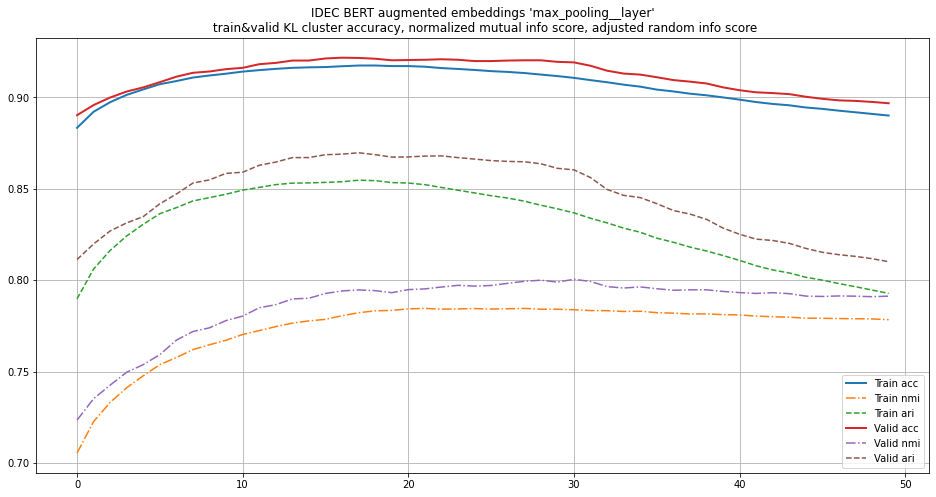

In [38]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'/kaggle/working/bertembaug_train_7.pt'))

idec = IDEC(autoencoder=model, n_clusters=7)
loss_fn = IDEC_loss(gamma=1.5e0)

optimizer = Adam(idec.parameters(), lr=1e-6)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    idec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 50,
    patience_threshold=(10,4),
    device = device,
    save_best_params_as='bertembaug_idec_weights_7.pt',
    title="IDEC BERT augmented embeddings 'max_pooling__layer'\n train&valid KL"
)

Not good. Through many attempts I didn't have the ability to get the stable performance of DEC or IDEC and catch the increase of performance. Hope that 'mean_pooling_layer' is much easier to adjust 

#### num. 8 'mean_pooling__layer' aug

In [10]:
embeddings = torch.Tensor(np.load(r'/kaggle/input/embaug-dataset/embaug_meanpooling_layer.npy'))

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
static_loader =  DataLoader(train_dataset, batch_size=256, pin_memory=False, shuffle=False)

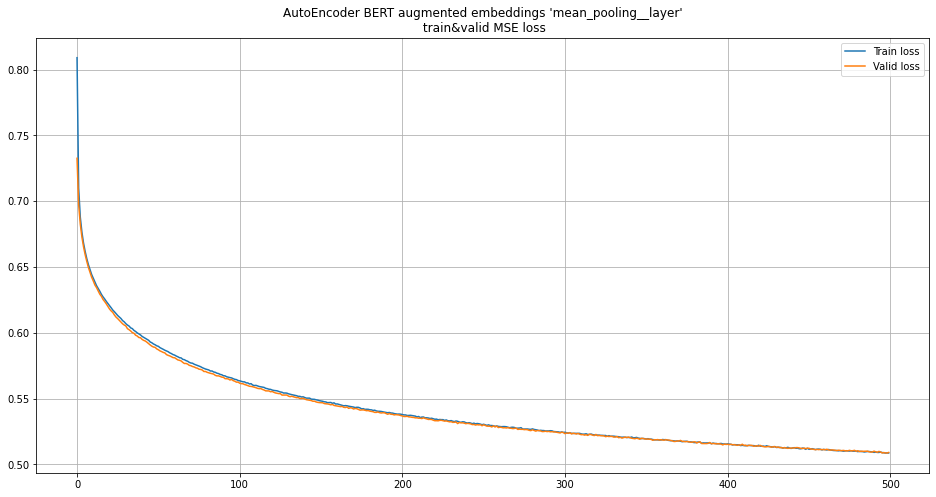

In [9]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.002)

optimizer = Adam(model.parameters(), lr=1e-4, )
# scheduler = StepLR(optimizer, step_size=100, gamma=10) 


whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 4),
    # save_best_params_as = './ae_weights/bertembaug_train_8.pt',
    title="AutoEncoder BERT augmented embeddings 'mean_pooling__layer'\n train&valid MSE"
)

In [10]:
# torch.save(model.state_dict(),'bertembaug_train_8.pt')

In [ ]:
"""save your time: it's .55 for 'mean_pooling_layer'"""

# km_baseline = KMeans(n_clusters=7, random_state=0, n_init=20).fit_predict(embeddings)

# cluster_acc(
#     num_labels.numpy(),
#     km_baseline
# )

## DEC

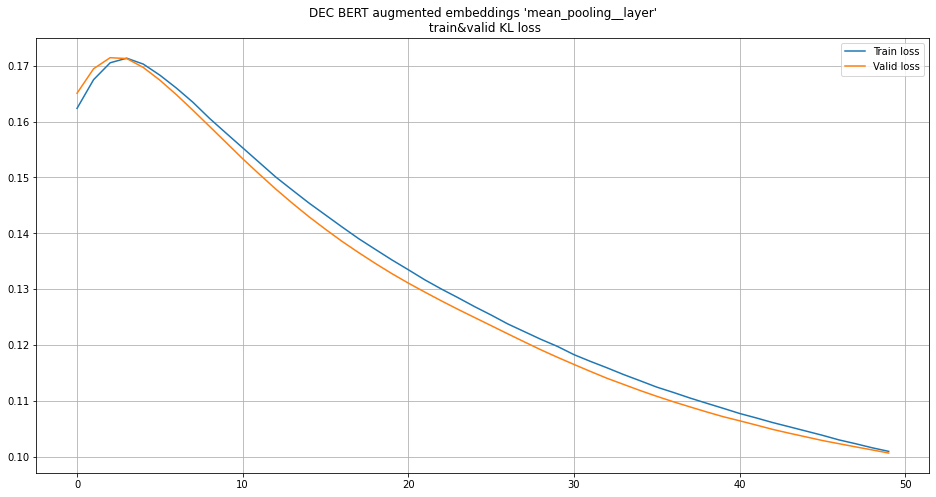

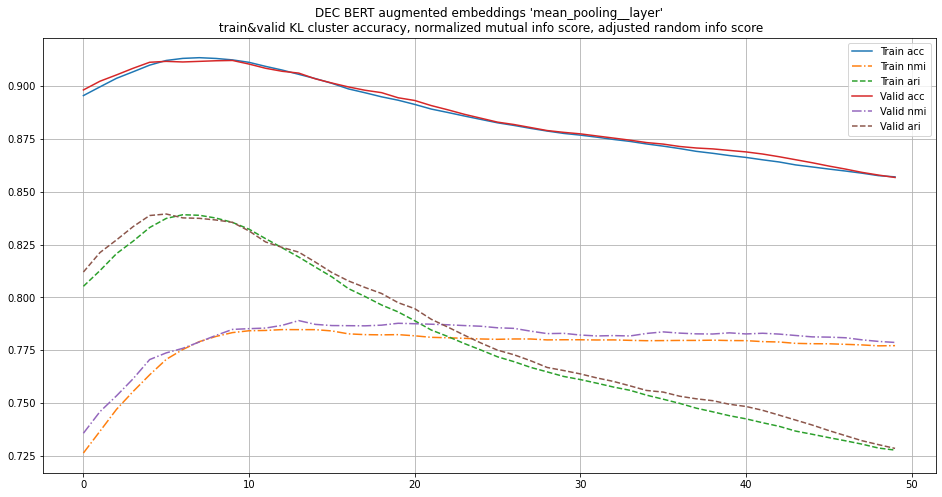

Model parameters saved to 'bertembaug_dec_weights_8.pt'


In [16]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'/kaggle/input/embaug-dataset/bertembaug_train_8.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-6)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 50,
    patience_threshold=(10,4),
    device = device,
    save_best_params_as='bertembaug_dec_weights_8.pt',
    title="DEC BERT augmented embeddings 'mean_pooling__layer'\n train&valid KL"
)

Performance curve is degrading.

In [49]:
# torch.save(dec.state_dict(), 'bertembaug_dec_weights_8.pt')

## IDEC

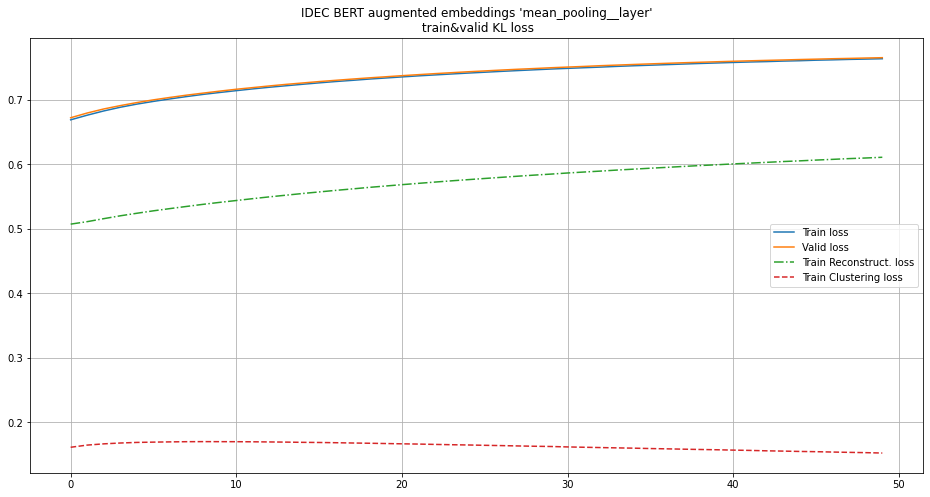

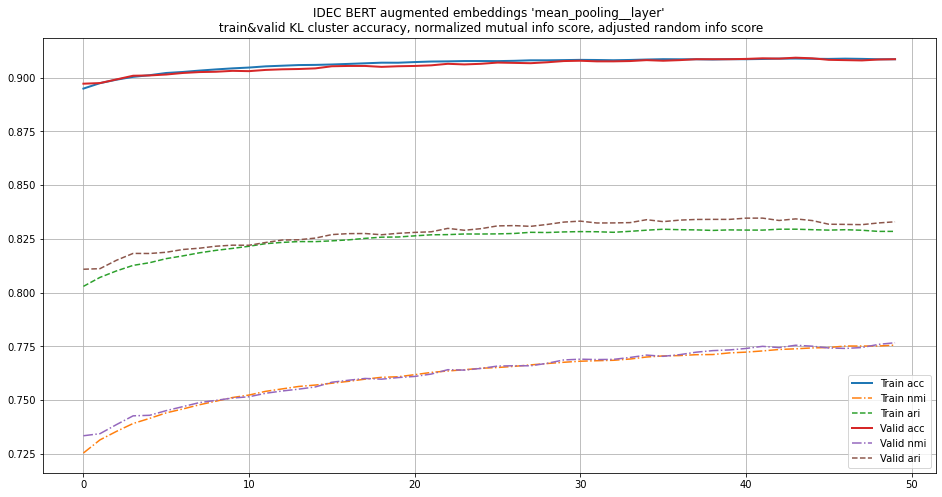

In [18]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'/kaggle/input/embaug-dataset/bertembaug_train_8.pt'))

idec = IDEC(autoencoder=model, n_clusters=7)
loss_fn = IDEC_loss(gamma=1e0)

optimizer = Adam(idec.parameters(), lr=1e-6)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    idec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 50,
    patience_threshold=(10,3),
    device = device,
    save_best_params_as='bertembaug_idec_weights_8.pt',
    title="IDEC BERT augmented embeddings 'mean_pooling__layer'\n train&valid KL"
)

In [20]:
torch.save(idec.state_dict(), 'bertembaug_idec_weights_8.pt')

Here we can see that IDEC indeed could be more preferable than DEC due to much stabler behaviour

In [33]:
# original embeddings n=7K
embeddings = torch.Tensor(np.load(r'/kaggle/input/embaug-dataset/emb_meanpooling_layer.npy'))

txt_labels = np.load(r'/kaggle/input/embaug-dataset/emb_txt_labels.npy', allow_pickle=True)
num_labels = torch.Tensor(
    np.load(r'/kaggle/input/embaug-dataset/emb_num_labels.npy')
)
full_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=-1)

full_loader = DataLoader(
    full_dataset,batch_size=256, shuffle=False, num_workers=0, pin_memory=True
)
results_idec = predict_cluster_accuracy(idec, full_loader, device, reassigned=True)
results_idec

Evaluate cluster accuracy: 100%|██████████| 28/28 [00:00<00:00, 281.92it/s]


{'accuracy': 0.9320803075608715,
 'predicted': array([0, 4, 0, ..., 3, 3, 3]),
 'features': array([[0.05716905, 0.60565466, 0.06511576, ..., 0.03680091, 0.09430475,
         0.03811847],
        [0.10987733, 0.10210969, 0.13179314, ..., 0.06636067, 0.3924262 ,
         0.06011133],
        [0.03162375, 0.7821852 , 0.03239763, ..., 0.02534054, 0.04711141,
         0.02514448],
        ...,
        [0.8773328 , 0.01136889, 0.04512088, ..., 0.01857466, 0.02018461,
         0.01377051],
        [0.9140484 , 0.00823644, 0.02780875, ..., 0.01671585, 0.0130752 ,
         0.00996886],
        [0.70566493, 0.03531853, 0.08732494, ..., 0.04474983, 0.05094874,
         0.02645908]], dtype=float32),
 'reassignment_dict': {0: 3, 1: 0, 2: 1, 3: 6, 4: 2, 5: 4, 6: 5}}

In [34]:
np.save('idecaug_results_dict.npy', results_idec)
np.save('idecaug_textcluster.npy', full_dataset.get_text_by_labels(results_idec['predicted']) )